# Cirrhosis Predictor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [3]:
data = pd.concat([train, test])
data.set_index('id', inplace=True)
data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


## Data Cleaning/Wrangling:

No NANS due to (given data - not me):
1. Drop all the rows where miss value (NA) were present in the Drug column
2. Impute missing values with mean results
3. One-hot encoding for all category attributes

In [4]:
data.isna().sum()

N_Days              0
Drug                0
Age                 0
Sex                 0
Ascites             0
Hepatomegaly        0
Spiders             0
Edema               0
Bilirubin           0
Cholesterol         0
Albumin             0
Copper              0
Alk_Phos            0
SGOT                0
Tryglicerides       0
Platelets           0
Prothrombin         0
Stage               0
Status           5271
dtype: int64

- Test set doesn't have its status column (competition determines whether you did good on test set)

Converting Age from days to years:

In [5]:
data['Age'] = data['Age'] / 365.0

## Descriptive Analysis:

In [6]:
data.shape

(13176, 19)

In [7]:
data.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status'],
      dtype='object')

In [8]:
data.dtypes

N_Days             int64
Drug              object
Age              float64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object

In [9]:
data.drop(columns={'Stage'}).describe()
# Stage = categorical

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
count,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000
mean,2033.583030,50.473962,2.596847,351.331815,3.544221,84.222416,1814.540225,114.197725,115.318534,264.746812,10.630823
std,1091.249998,9.978656,3.828640,197.413677,0.349706,76.558760,1916.383653,48.861248,52.557379,87.511668,0.786116
min,41.000000,26.295890,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000
25%,1234.000000,42.772603,0.700000,248.000000,3.350000,39.000000,824.000000,75.950000,84.000000,210.000000,10.000000
50%,1874.000000,51.284932,1.100000,299.000000,3.580000,63.000000,1166.000000,106.950000,104.000000,264.000000,10.600000
75%,2689.000000,56.668493,3.000000,390.000000,3.770000,102.000000,1840.000000,137.950000,139.000000,316.000000,11.000000
max,4795.000000,78.493151,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000


## EDA:

Correlation Matrix:

In [10]:
numeric_feats = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
corr = data[numeric_feats].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

(corr
    .style
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
    .highlight_null(color='f1f1f1')
    .format(precision=2)
)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
N_Days,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Age,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bilirubin,-0.34,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan
Cholesterol,-0.14,-0.06,0.31,nan,nan,nan,nan,nan,nan,nan,nan
Albumin,0.26,-0.11,-0.30,-0.09,nan,nan,nan,nan,nan,nan,nan
Copper,-0.28,0.09,0.44,0.17,-0.23,nan,nan,nan,nan,nan,nan
Alk_Phos,-0.02,0.02,0.13,0.13,-0.09,0.13,nan,nan,nan,nan,nan
SGOT,-0.23,-0.02,0.36,0.34,-0.21,0.33,0.13,nan,nan,nan,nan
Tryglicerides,-0.18,0.02,0.32,0.28,-0.11,0.28,0.10,0.15,nan,nan,nan
Platelets,0.14,-0.10,-0.08,0.09,0.14,-0.10,0.04,-0.04,0.02,nan,nan


- No strong linear correlation, but Bilirubin has relatively the strongest correlation w/ other variables

Distribution of Status:

,count
Status,
C,4965
D,2665
CL,275


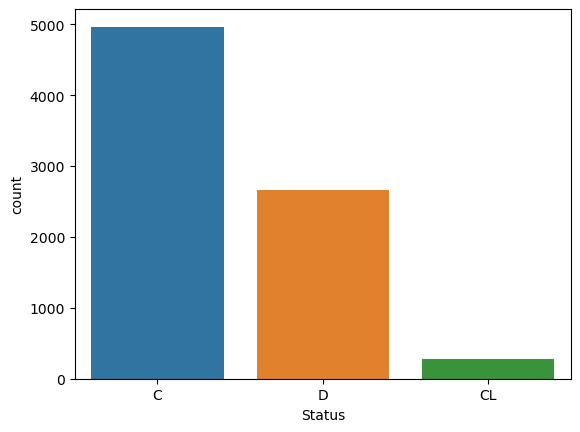

In [11]:
status = data[['Status']].value_counts().reset_index()

sns.barplot(status, 
            x='Status',
            y='count');
status.set_index('Status')

- Class imbalance

Histograms for all quantitative variables (includes Stage):

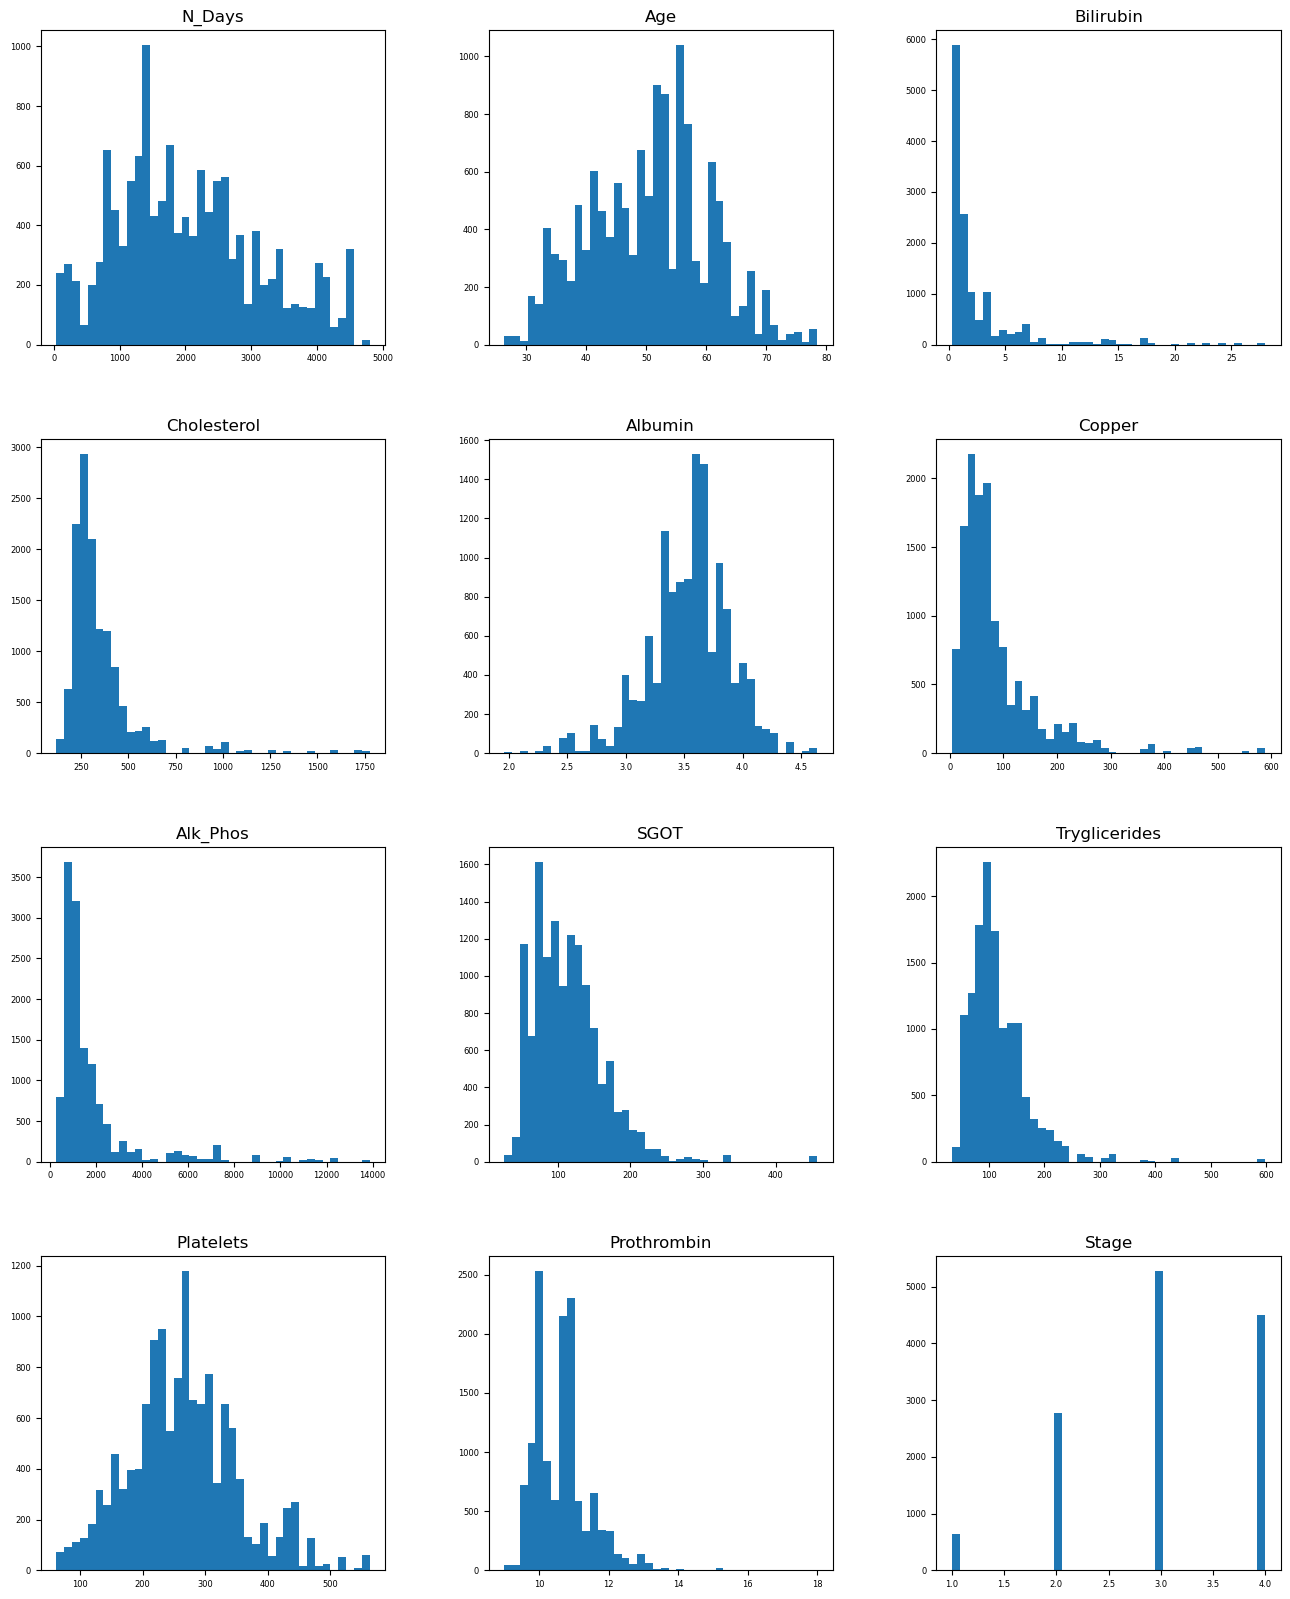

In [12]:
ax = data.hist(figsize=(16, 20), 
               bins=40, 
               xlabelsize=6, 
               ylabelsize=6);

for row in ax:
    for subplot in row:
        subplot.grid(False)

## Predictive Analysis:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

Splitting the train set into training, validation, and test sets:

In [14]:
data_X = train.drop(columns={'Status'})
data_Y = train.Status

X, test_X, Y, test_Y = train_test_split(
    data_X, data_Y,
    test_size=.2, random_state=42069
)

train_X, val_X, train_Y, val_Y = train_test_split(
    X, Y,
    test_size=.25, random_state=42069
)

### Baseline Model:

In [15]:
categorical = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
std = ['Age', 'Albumin', 'Platelets']
log_std = ['N_Days', 'Bilirubin', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Copper', 'Alk_Phos']

categorical_transformer = Pipeline(
    steps=
    [
        ('one hot encode', OneHotEncoder())
    ]
)

std_transformer = Pipeline(
    steps=
    [
        ('standardization', StandardScaler())
    ]
)


log_std_transformer = Pipeline(
    steps=
    [
        ('log', FunctionTransformer(np.log)),
        ('standardization', StandardScaler())
    ]
)


preproc_base = ColumnTransformer(
    transformers =
    [
        ('one hot encode', categorical_transformer, categorical),
        ('standardize', std_transformer, std),
        ('log std', log_std_transformer, log_std)
    ],
    remainder='drop'
)

base_pl = Pipeline(
    [
        ('preprocessor', preproc_base),
        ('rfc', RandomForestClassifier(
                random_state=69,
                class_weight='balanced',
                criterion='entropy',
                max_features='sqrt'
            )
        )
    ]
)

Fitting baseline model onto training set:

In [16]:
base_pl.fit(train_X, train_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Drug', 'Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders',
                                                   'Edema', 'Stage']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['Age', 'Albumin',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Bilirubin',
                                                   'SGOT', 'Tryglicerides',
                                                   'Prothrombin', 'Cholesterol',
                                                   'Copper', 'Alk_Phos'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        random_state=69))])

In [17]:
from sklearn.model_selection import GridSearchCV
hyperparams = {
    'rfc__criterion'   : ['gini', 'entropy'],
    'rfc__max_features': ['sqrt', 'log2', None],
    'rfc__class_weight': ['balanced'],
}

# grid_search = GridSearchCV(base_pl, hyperparams, scoring='neg_log_loss')
# grid_search.fit(train_X, train_Y)
# print(grid_search.best_params_)

# Result: {'rfc__class_weight': 'balanced', 'rfc__criterion': 'entropy', 'rfc__max_features': 'sqrt'}

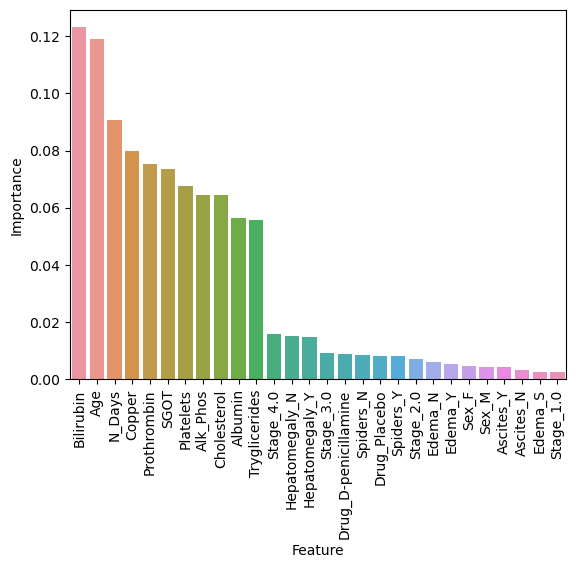

In [18]:
feat_importances = base_pl.named_steps['rfc'].feature_importances_

# Get the names of the features after preprocessing
feature_names = preproc_base.transformers_[0][1]['one hot encode'].get_feature_names_out(categorical).tolist()
feature_names = feature_names + std + log_std

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feat_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feat_fig = sns.barplot(data=feature_importance_df,
                       x='Feature', 
                       y='Importance');
feat_fig.set_xticklabels(labels=feature_importance_df.Feature, rotation=90);

In [19]:
base_pl_predicted_train_Y = base_pl.predict(train_X)
base_pl_predicted_val_Y   = base_pl.predict(val_X)
base_pl_predicted_test_Y  = base_pl.predict(test_X)

In [20]:
print(classification_report(train_Y.values.flatten(), base_pl_predicted_train_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00      2978
          CL       1.00      1.00      1.00       170
           D       1.00      1.00      1.00      1595

    accuracy                           1.00      4743
   macro avg       1.00      1.00      1.00      4743
weighted avg       1.00      1.00      1.00      4743



In [21]:
print(classification_report(val_Y.values.flatten(), base_pl_predicted_val_Y))

              precision    recall  f1-score   support

           C       0.83      0.94      0.88      1007
          CL       0.86      0.16      0.27        38
           D       0.83      0.68      0.75       536

    accuracy                           0.83      1581
   macro avg       0.84      0.59      0.63      1581
weighted avg       0.83      0.83      0.82      1581



In [22]:
print(classification_report(test_Y.values.flatten(), base_pl_predicted_test_Y))

              precision    recall  f1-score   support

           C       0.83      0.94      0.88       980
          CL       0.70      0.10      0.18        67
           D       0.82      0.72      0.76       534

    accuracy                           0.83      1581
   macro avg       0.78      0.59      0.61      1581
weighted avg       0.82      0.83      0.81      1581



In [23]:
base_pl_predicted_train_Y = base_pl.predict_proba(train_X)
base_pl_predicted_val_Y   = base_pl.predict_proba(val_X)
base_pl_predicted_test_Y  = base_pl.predict_proba(test_X)

(
    log_loss(train_Y.values.flatten(), base_pl_predicted_train_Y), 
    log_loss(val_Y.values.flatten(), base_pl_predicted_val_Y),
    log_loss(test_Y.values.flatten(), base_pl_predicted_test_Y)
)

(0.1186466195852396, 0.4795777960370426, 0.566408379301709)

Reflection of Baseline Model:
- Used all variables
- One hot encoded all categorical features
- Standardized all the riughly normal distributed variables
- Log transformed - then standardized - all right skewed variables

Model obviously overfit training set. The log loss metric was low, but was higher on validation and test sets.
- Lower amount of features
- Address class inbalance

### Final Model:

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
categorical = ['Drug']
std = ['N_Days', 'Age', 'Platelets']
log_std = ['SGOT', 'Cholesterol', 'Copper']
sparse_dists = ['Bilirubin', 'Alk_Phos', 'Prothrombin']

categorical_transformer = Pipeline(
    steps=
    [
        ('one hot encode', OneHotEncoder())
    ]
)

std_transformer = Pipeline(
    steps=
    [
        ('standardization', StandardScaler())
    ]
)

log_std_transformer = Pipeline(
    steps=
    [
        ('log', FunctionTransformer(np.log)),
        ('standardization', StandardScaler())
    ]
)

sparse_transformer = Pipeline(
    steps=
    [
        ('min-max', MinMaxScaler())
    ]
)

preproc_final = ColumnTransformer(
    transformers =
    [
        ('one hot encode', categorical_transformer, categorical),
        ('standardize', std_transformer, std),
        ('log std', log_std_transformer, log_std),
        ('min-max', sparse_transformer, sparse_dists)
    ],
    remainder='drop'
)

final_pl = Pipeline(
    [
        ('preprocessor', preproc_final),
        ('rfc', RandomForestClassifier(
                random_state=69,
                class_weight='balanced',
                criterion='gini',
                max_features='sqrt'
            )
        )
    ]
)

In [26]:
final_pl.fit(train_X, train_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Drug']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Age',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['SGOT', 'Cholesterol',
                                                   'Copper']),
                                                 ('min-max',
                                                  Pipeline(steps=[('min-max',
                                                                   MinMaxScaler())]),
                                                  ['Bilirubin', 'Alk_Phos',
                                                   'Prothrombin'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=69))])

In [27]:
hyperparams = {
    'rfc__criterion'   : ['gini', 'entropy'],
    'rfc__max_features': ['sqrt', 'log2', None],
    'rfc__class_weight': ['balanced'],
}

# grid_search = GridSearchCV(final_pl, hyperparams, scoring='neg_log_loss')
# grid_search.fit(train_X, train_Y)
# print(grid_search.best_params_)

# Result: {'rfc__class_weight': 'balanced', 'rfc__criterion': 'gini', 'rfc__max_features': 'sqrt'}

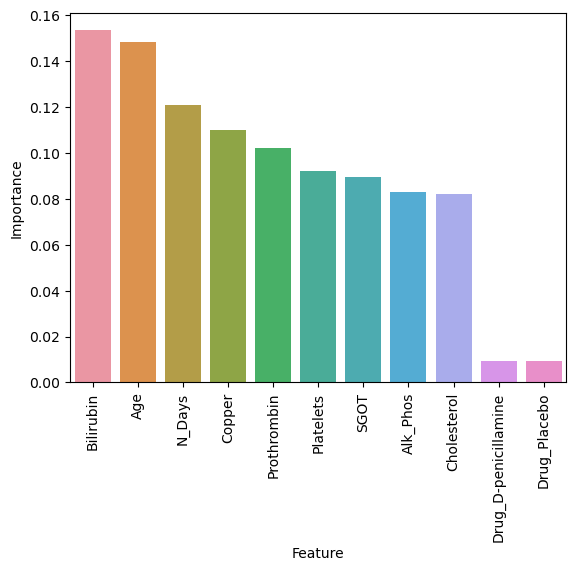

In [28]:
feat_importances = final_pl.named_steps['rfc'].feature_importances_

# Get the names of the features after preprocessing
feature_names = preproc_final.transformers_[0][1]['one hot encode'].get_feature_names_out(categorical).tolist()
feature_names = feature_names + std + log_std + sparse_dists

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feat_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feat_fig = sns.barplot(data=feature_importance_df,
                       x='Feature', 
                       y='Importance');
feat_fig.set_xticklabels(labels=feature_importance_df.Feature, rotation=90);

In [29]:
final_pl_predicted_train_Y = final_pl.predict(train_X)
final_pl_predicted_val_Y   = final_pl.predict(val_X)
final_pl_predicted_test_Y  = final_pl.predict(test_X)

In [30]:
print(classification_report(train_Y.values.flatten(), final_pl_predicted_train_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00      2978
          CL       0.99      1.00      1.00       170
           D       1.00      1.00      1.00      1595

    accuracy                           1.00      4743
   macro avg       1.00      1.00      1.00      4743
weighted avg       1.00      1.00      1.00      4743



In [31]:
print(classification_report(val_Y.values.flatten(), final_pl_predicted_val_Y))

              precision    recall  f1-score   support

           C       0.83      0.93      0.88      1007
          CL       0.67      0.16      0.26        38
           D       0.81      0.68      0.74       536

    accuracy                           0.82      1581
   macro avg       0.77      0.59      0.62      1581
weighted avg       0.82      0.82      0.82      1581



In [32]:
print(classification_report(test_Y.values.flatten(), final_pl_predicted_test_Y))

              precision    recall  f1-score   support

           C       0.84      0.93      0.88       980
          CL       0.79      0.16      0.27        67
           D       0.81      0.73      0.77       534

    accuracy                           0.83      1581
   macro avg       0.81      0.61      0.64      1581
weighted avg       0.83      0.83      0.82      1581



In [44]:
final_pl_predicted_train_Y = final_pl.predict_proba(train_X)
final_pl_predicted_val_Y   = final_pl.predict_proba(val_X)
final_pl_predicted_test_Y  = final_pl.predict_proba(test_X)

(
    log_loss(train_Y.values.flatten(), final_pl_predicted_train_Y), 
    log_loss(val_Y.values.flatten(),   final_pl_predicted_val_Y),
    log_loss(test_Y.values.flatten(),  final_pl_predicted_test_Y)
)

(0.11785709864674453, 0.11646288929942221, 0.11473686595264715)

Fitting onto all of training data:

In [34]:
final_pl.fit(data_X, data_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Drug']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Age',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['SGOT', 'Cholesterol',
                                                   'Copper']),
                                                 ('min-max',
                                                  Pipeline(steps=[('min-max',
                                                                   MinMaxScaler())]),
                                                  ['Bilirubin', 'Alk_Phos',
                                                   'Prothrombin'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=69))])

In [35]:
final_pl.predict_proba(data_X)

array([[0.01, 0.  , 0.99],
       [0.9 , 0.  , 0.1 ],
       [0.  , 0.  , 1.  ],
       ...,
       [0.06, 0.  , 0.94],
       [0.39, 0.  , 0.61],
       [1.  , 0.  , 0.  ]])

Probabilities for each class on the individuals in the entire test set:

In [36]:
final_pl.predict_proba(test)

array([[0.65446025, 0.02      , 0.32553975],
       [0.54      , 0.09      , 0.37      ],
       [0.31      , 0.        , 0.69      ],
       ...,
       [1.        , 0.        , 0.        ],
       [0.96      , 0.01      , 0.03      ],
       [0.26      , 0.01      , 0.73      ]])

In [56]:
submission = pd.DataFrame(final_pl.predict_proba(test))
submission.columns = final_pl.classes_
submission['id'] = test.id
submission = submission[['id', 'C',	'CL', 'D']]
submission.set_index('id', inplace=True)
submission

,C,CL,D
id,,,
7905,0.654460,0.02,0.325540
7906,0.540000,0.09,0.370000
7907,0.310000,0.00,0.690000
7908,0.910000,0.00,0.090000
7909,0.800000,0.02,0.180000
...,...,...,...
13171,0.630000,0.19,0.180000
13172,0.886822,0.00,0.113178
13173,1.000000,0.00,0.000000


File to submit to competition:

In [57]:
submission.to_csv('submission.csv')